In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# parameters

num_clusters=5             # number of components (clusters) in mixture model
N=50                       # total number of samples of training data
step=0.1
grid=np.arange(-3,3+step,step)     # test data grid for each dimension
num_neighbors=3                    # number of neighbors used in nearest neighbors

# 2D Gaussian Mixture data

In [3]:
# mixture models

Gmean=np.random.randn(2,num_clusters)  # locations of centers of clusters for green class
Rmean=np.random.randn(2,num_clusters)  # -"- red class
Gmean

array([[ 2.28253316,  1.25792651, -0.08782747,  0.93544149,  1.6632034 ],
       [-0.66277866,  1.01878007, -0.73063043,  0.15556737,  0.19409825]])

In [4]:
# training data

samples=np.zeros((2,N))                   # locations of samples in 2 dimensions
class_samples=np.zeros((N,1))             # class of each one (green or red)
cluster_variance=0.1                      # variance of each cluster around its mean
for n in range(1,int(N/2)):
    Gcluster=int(np.ceil(np.random.rand(1)*num_clusters))    # select green cluster
    Rcluster=int(np.ceil(np.random.rand(1)*num_clusters))    # -"- red
    samples[:,n]=Gmean[:,Gcluster-1]+np.sqrt(cluster_variance)*np.random.randn(2) # generate green sample
    samples[:,int(n+N/2)]=Rmean[:,Rcluster-1]+np.sqrt(cluster_variance+0.2)*np.random.randn(2)   # -"- red
    class_samples[n]=1 # green
    class_samples[int(n+N/2)]=0 # red

In [5]:
# test data - basically a 2-D grid

test_samples=np.zeros((2,np.size(grid)**2))                      # locations of test samples
for n1 in range(1,np.size(grid)):
    for n2 in range(1,np.size(grid)):
        test_samples[0,int(n1+np.size(grid)*(n2-1))]=grid[n1]      # first coordinate
        test_samples[1,int(n1+np.size(grid)*(n2-1))]=grid[n2]      # second 

In [6]:
# class_samples                  # Target

In [7]:
# np.transpose(samples)          # Input

In [8]:
np.transpose(test_samples).shape

(3721, 2)

# Models

# Linear Model

In [9]:
# run classifiers on test grid

# linear model

beta,_,_,_ = np.linalg.lstsq(class_samples,np.transpose(samples)) # compute coefficients of least squares
beta=np.reshape(beta, (2,))
test_linear=(np.dot(beta,test_samples)>0.5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


# Nearest Neighbor Model

In [10]:
# nearest neighbors 

test_NN=np.zeros((np.size(grid)**2,1))           # classification results on test data
for n1 in range(0,np.size(grid)-1):
    for n2 in range (0,np.size(grid)-1):
        distances=(grid[n1]-samples[0,:])**2+(grid[n2]-samples[1,:])**2  # distances to training samples
        distances_sort = np.sort(distances)
        distances_index = np.argsort(distances)
        neighbors=distances_index[0:num_neighbors]
        class_predicted=((np.sum(class_samples[neighbors-1])/num_neighbors)>0.5) # NN classifier
        test_NN[n1+np.size(grid)*(n2-1)-1]=class_predicted    # store classification

# Baysian Classifier

In [11]:
# Example of calculating class probabilities
import math
from math import sqrt
from math import pi
from math import exp
# Split the dataset by class values, returns a dictionary
def separate_by_class(dataset):

	separated = dict()
 
	for i in range(len(dataset)):
		vector = dataset[i]
		class_value = vector[-1] # identify class value Red(0) or Green(1)
		if (class_value not in separated):
			separated[class_value] = list()
		separated[class_value].append(vector)
	return separated
 
# Calculate the mean of a list of numbers
def mean(numbers):
	return sum(numbers)/float(len(numbers))
 
# Calculate the standard deviation of a list of numbers
def stdev(numbers):
	avg = mean(numbers)
	variance = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
	return sqrt(variance)
 
# Calculate the mean, stdev and count for each column in a dataset
def summarize_dataset(dataset):
	summaries = [(mean(column), stdev(column), len(column)) for column in zip(*dataset)]
	del(summaries[-1])
	return summaries
 
# Split dataset by class then calculate statistics for each row
def summarize_by_class(dataset):
	separated = separate_by_class(dataset)
	summaries = dict()
	for class_value, rows in separated.items():
		summaries[class_value] = summarize_dataset(rows)
	return summaries
 
# Calculate the Gaussian probability distribution function for x
def calculate_probability(x, mean, stdev):
	exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
	return (1 / (sqrt(2 * pi) * stdev)) * exponent
 
# Calculate the probabilities of predicting each class for a given row
def calculate_class_probabilities(summaries, row):
	total_rows = sum([summaries[label][0][2] for label in summaries])
	probabilities = dict()
	for class_value, class_summaries in summaries.items():
		probabilities[class_value] = summaries[class_value][0][2]/float(total_rows)
		for i in range(len(class_summaries)):
			mean, stdev, _ = class_summaries[i]
			probabilities[class_value] *= calculate_probability(row[i], mean, stdev)
	return probabilities
 
# Predict the class for a given row
def predict(summaries, row):
	probabilities = calculate_class_probabilities(summaries, row)
	best_label, best_prob = None, -1
	for class_value, probability in probabilities.items():
		if best_label is None or probability > best_prob:
			best_prob = probability
			best_label = class_value
	return best_label

In [12]:
samples_T=np.transpose(samples)
#(cordinate_x, cordinate_y,class value defining the Green(1) or Red(0) 
dataset=[0]*N             # An empty list to store data

# class_samples, np.transpose(samples)
#{0:xyz , 1: abc}
for i in range(samples_T.shape[0]):
  dataset[i]= np.append( samples_T[i], class_samples[i] )


In [13]:
# Test calculating class probabilities

summaries = summarize_by_class(dataset)
probabilities = calculate_class_probabilities(summaries, dataset[0])
print(probabilities)

{0.0: 0.08199502233466063, 1.0: 0.052041657485052635}


In [14]:
summaries

{0.0: [(-0.42646788021120885, 1.000294067133731, 26),
  (0.0003838089064984643, 0.9213780269023567, 26)],
 1.0: [(1.107490345341973, 0.767650010972453, 24),
  (0.1402623739338578, 0.6603625936959705, 24)]}

In [41]:
test_samples_T=np.transpose(test_samples)
label=[0]*test_samples_T.shape[0]

for i in range(test_samples_T.shape[0]):
  label[i] = predict(summaries, test_samples_T[i]   ) # Baysian Classifier Prediction
#print('Data=%s, Predicted: %s' % (test_samples_T[i] , label))

# QDA

In [17]:
import numpy

class QDA:
    def fit(self, X, t):
        self.priors = dict()
        self.means = dict()
        self.covs = dict()
        
        self.classes = np.unique(t)

        for c in self.classes:
            X_c = X[t == c]
            self.priors[c] = X_c.shape[0] / X.shape[0]
            self.means[c] = np.mean(X_c, axis=0)
            self.covs[c] = np.cov(X_c, rowvar=False)

    def predict(self, X):
        preds = list()
        for x in X:
            posts = list()
            for c in self.classes:
                prior = np.log(self.priors[c])
                inv_cov = np.linalg.inv(self.covs[c])
                inv_cov_det = np.linalg.det(inv_cov)
                diff = x-self.means[c]
                likelihood = 0.5*np.log(inv_cov_det) - 0.5*diff.T @ inv_cov @ diff
                post = prior + likelihood
                posts.append(post)
            pred = self.classes[np.argmax(posts)]
            preds.append(pred)
        return np.array(preds)

In [18]:
data= pd.DataFrame(dataset)

In [20]:
X = data.iloc[:, 0:2]
t = data.iloc[:, -1]

qda = QDA()
qda.fit(X, t)
preds_tr = qda.predict(X)

In [21]:
preds_test = qda.predict(test_samples_T)

# Plot using Linear CLassifier

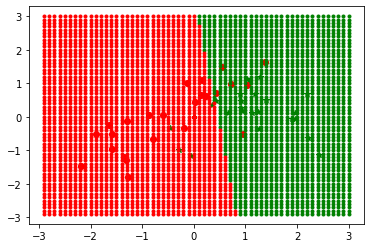

In [23]:
# show data

## identify location indices (in test grid) that are red and green
r_locations=np.argwhere(np.logical_not(test_linear))
g_locations=np.argwhere(test_linear)
#
## linear classification plot
plt.subplot(111)
plt.plot(samples[0,1:int(N/2)],samples[1,1:int(N/2)],'g*',   # green training samples
    samples[0,int(N/2+1):N],samples[1,int(N/2+1):N],'ro',    # red training 
    test_samples[0,g_locations],test_samples[1,g_locations],'g.', # green test
    test_samples[0,r_locations],test_samples[1,r_locations],'r.') # red test
   
plt.xlim=(-3,3) # boundaries for figure aligned with grid
plt.ylim=(-3,3)

# Plot using Nearest Neighbors

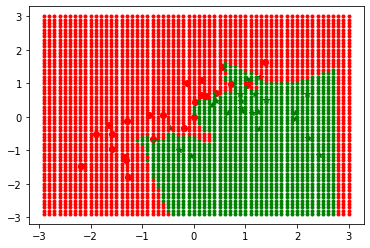

In [40]:
# identify location indices (in test grid) that are red and green
r_locations=np.argwhere(np.logical_not(test_NN))
g_locations=np.argwhere(test_NN)

# NN plot
plt.subplot(111)
plt.plot(samples[0,1:int(N/2-1)],samples[1,1:int(N/2-1)],'g*',            
    samples[0,int(N/2):N-1],samples[1,int(N/2):N-1],'ro',                
    test_samples[0,g_locations-1],test_samples[1,g_locations-1],'g.',     
    test_samples[0,r_locations-1],test_samples[1,r_locations-1],'r.')    
   
plt.xlim=(-3,3) # boundaries for figure aligned with grid
plt.ylim=(-3,3)

# Baysian Classifier

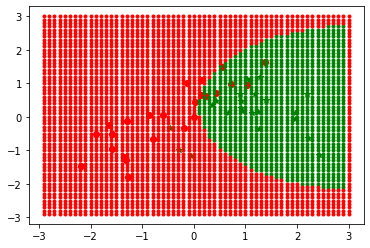

In [25]:
# identify location indices (in test grid) that are red and green
r_locations=np.argwhere(np.logical_not(label))
g_locations=np.argwhere(label)

# NN plot
plt.subplot(111)
plt.plot(samples[0,1:int(N/2-1)],samples[1,1:int(N/2-1)],'g*',   
    samples[0,int(N/2):N-1],samples[1,int(N/2):N-1],'ro',                 
    test_samples[0,g_locations-1],test_samples[1,g_locations-1],'g.',   
    test_samples[0,r_locations-1],test_samples[1,r_locations-1],'r.')      
   
plt.xlim=(-3,3) # boundaries for figure aligned with grid
plt.ylim=(-3,3)

# QDA

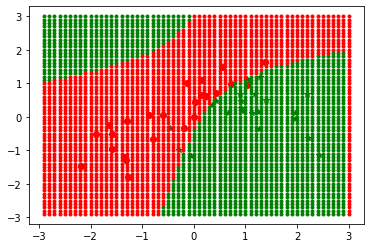

In [26]:
# identify location indices (in test grid) that are red and green
r_locations=np.argwhere(np.logical_not(preds_test))
g_locations=np.argwhere(preds_test)

# NN plot
plt.subplot(111)
plt.plot(samples[0,1:int(N/2-1)],samples[1,1:int(N/2-1)],'g*',            
    samples[0,int(N/2):N-1],samples[1,int(N/2):N-1],'ro',                 
    test_samples[0,g_locations-1],test_samples[1,g_locations-1],'g.',      
    test_samples[0,r_locations-1],test_samples[1,r_locations-1],'r.')      
   
plt.xlim=(-3,3) # boundaries for figure aligned with grid
plt.ylim=(-3,3)

# Weighted KNN

In [27]:
data.head()

,0,1,2
0,0.000000,0.000000,0.0
1,1.289108,1.184321,1.0
2,-0.286540,-0.981333,1.0
3,2.196059,0.671146,1.0
4,1.121433,0.124737,1.0


In [28]:
data.shape

(50, 3)

In [30]:
data.columns =['X1', 'X2', 'Y']

In [31]:
data_0=data.loc[data['Y'] == 0]
data_1=data.loc[data['Y'] == 1]

In [32]:
data_1.iloc[1]

X1   -0.286540
X2   -0.981333
Y     1.000000
Name: 2, dtype: float64

In [33]:
import math 

In [34]:
def weightedkNN(p,k): #points,
  d_0=[] 
  d_1=[]

  for index, i in data_0.iterrows():  # for i in range(data_0.shape[0]):
    euclidean_distance_0 = math.sqrt((i[0]-p[0])**2 + (i[1]-p[1])**2)
    d_0.append(euclidean_distance_0)

  for index, j in data_1.iterrows():  # for i in range(data_0.shape[0]):
    euclidean_distance_1 = math.sqrt((j[0]-p[0])**2 + (j[1]-p[1])**2)
    d_1.append(euclidean_distance_1)
  
  d_0= sorted(d_0)[:k] 
  d_1= sorted(d_1)[:k] 

  w0=w1=0
  dem= k*(k + 1 ) / 2

  # Class 0 -- w0
  m0=k

  #for m in range(k,1,-1):
  for d0 in d_0:
    while m0!=0:
      w0 += (m0/dem)*d0
      m0-=1

  # Class 1 -- w1
  m1=k
  
  #for m in range(k,1,-1):
  for d1 in d_1:
    while m1!=0:
      w1 += (m1/dem)*d1
      m1-=1

  return 0 if w0<w1 else 1
  

In [38]:
# weightedkNN(data,p,k=3)
label_wknn=[0]*test_samples_T.shape[0]

for i in range(test_samples_T.shape[0]):
  label_wknn[i] = weightedkNN(test_samples_T[i],k=3)  #data,
#print('Data=%s, Predicted: %s' % (test_samples_T[i] , label))

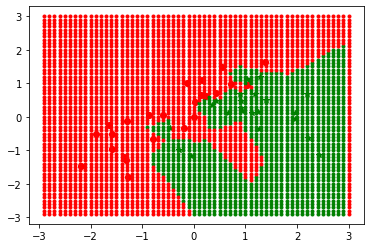

In [39]:
# identify location indices (in test grid) that are red and green
r_locations=np.argwhere(np.logical_not(label_wknn))
g_locations=np.argwhere(label_wknn)

# NN plot
plt.subplot(111)
plt.plot(samples[0,1:int(N/2-1)],samples[1,1:int(N/2-1)],'g*',  # green training samples
    samples[0,int(N/2):N-1],samples[1,int(N/2):N-1],'ro',       # red training 
    test_samples[0,g_locations-1],test_samples[1,g_locations-1],'g.',  # green test
    test_samples[0,r_locations-1],test_samples[1,r_locations-1],'r.')  # red
   
plt.xlim=(-3,3) # boundaries for figure aligned with grid
plt.ylim=(-3,3)